In [3]:
import pandas as pd
import numpy as np

from IPython.display import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [4]:
df_train = pd.read_csv('train.csv', encoding='utf8', index_col='_id')
df_test = pd.read_csv('test.csv', encoding='utf8', index_col='_id')

In [5]:
df_train.info() #full, got objects

<class 'pandas.core.frame.DataFrame'>
Index: 24712 entries, df7489733b004bbe40d3d37b34f82419 to 46d0d25dfd1def79632dd437261d0b5c
Data columns (total 21 columns):
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64

In [4]:
df_test.info() #no tgt column. full, got objects

<class 'pandas.core.frame.DataFrame'>
Index: 16476 entries, 66810d8e6bf2b41c880a7bc6c8a1e295 to 82db4c5dd22e8182b30917571fe77c4d
Data columns (total 20 columns):
age               16476 non-null int64
job               16476 non-null object
marital           16476 non-null object
education         16476 non-null object
default           16476 non-null object
housing           16476 non-null object
loan              16476 non-null object
contact           16476 non-null object
month             16476 non-null object
day_of_week       16476 non-null object
duration          16476 non-null int64
campaign          16476 non-null int64
pdays             16476 non-null int64
previous          16476 non-null int64
poutcome          16476 non-null object
emp.var.rate      16476 non-null float64
cons.price.idx    16476 non-null float64
cons.conf.idx     16476 non-null float64
euribor3m         16476 non-null float64
nr.employed       16476 non-null float64
dtypes: float64(5), int64(5), object(1

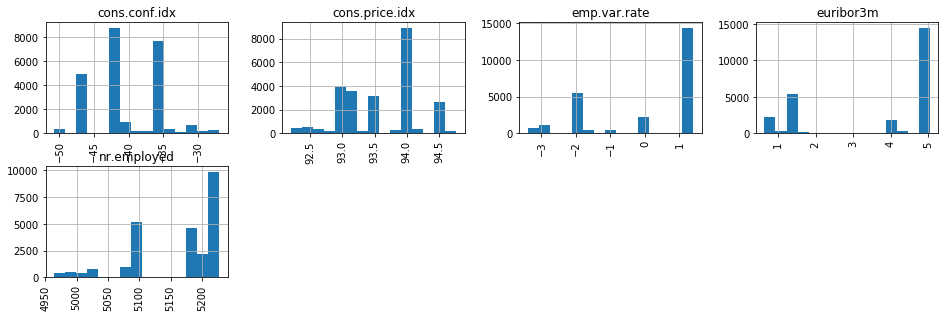

In [7]:
# train.columns
%matplotlib inline
import matplotlib.pyplot as plt
_ = df_train[df_train.dtypes[df_train.dtypes == 'float64'].index].hist(layout=(4, 4), figsize=(16, 10), xrot=90, bins=15)

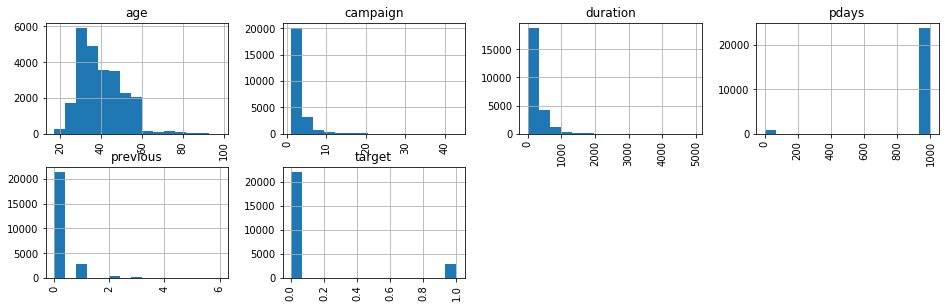

In [8]:
_ = df_train[df_train.dtypes[df_train.dtypes == 'int64'].index].hist(layout=(4, 4), figsize=(16, 10), xrot=90, bins=15)

In [16]:
for col in df_train[df_train.dtypes[df_train.dtypes == 'object'].index]:
    print(df_train[col].value_counts())

admin.           6254
blue-collar      5621
technician       3987
services         2391
management       1758
retired          1001
entrepreneur      853
self-employed     850
housemaid         652
unemployed        594
student           554
unknown           197
Name: job, dtype: int64
married     14871
single       7041
divorced     2755
unknown        45
Name: marital, dtype: int64
university.degree      7309
high.school            5737
basic.9y               3565
professional.course    3112
basic.4y               2523
basic.6y               1399
unknown                1060
illiterate                7
Name: education, dtype: int64
no         19567
unknown     5144
yes            1
Name: default, dtype: int64
yes        12934
no         11156
unknown      622
Name: housing, dtype: int64
no         20334
yes         3756
unknown      622
Name: loan, dtype: int64
cellular     15729
telephone     8983
Name: contact, dtype: int64
may    8199
jul    4364
aug    3731
jun    3191
nov    242

In [11]:
only_target = df_train[df_train['target'] == 1]

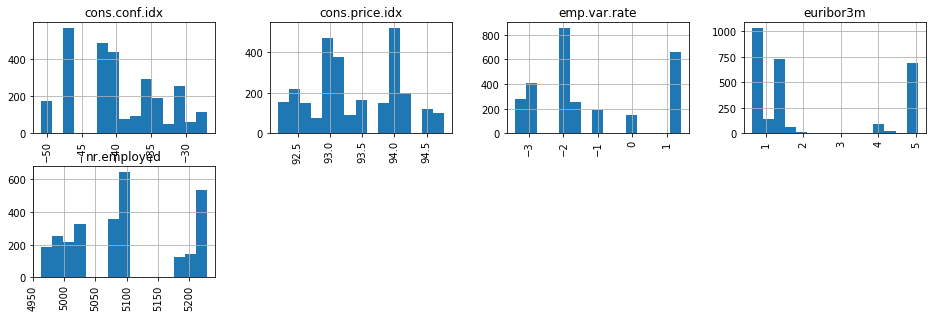

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = only_target[only_target.dtypes[only_target.dtypes == 'float64'].index].hist(layout=(4, 4), figsize=(16, 10), xrot=90, bins=15)

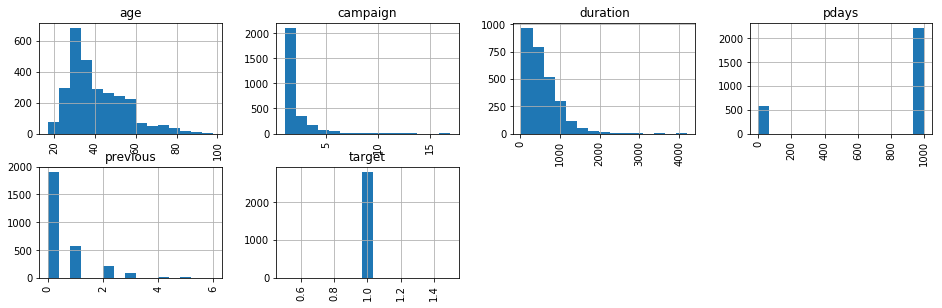

In [13]:
_ = only_target[only_target.dtypes[only_target.dtypes == 'int64'].index].hist(layout=(4, 4), figsize=(16, 10), xrot=90, bins=15)

In [14]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    df_output = df_output.drop(['month', 'day_of_week', 'default', 'contact', 'pdays', 'nr.employed'], axis = 1)

    # category code
    df_output = pd.get_dummies(df_output, columns=['job', 'marital', 'education', 'housing', 'loan', 'poutcome'])
        
    return df_output

In [15]:
x = preproc_data(df_train).drop(['target'], axis=1)
y = df_train['target']

In [29]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24712 entries, df7489733b004bbe40d3d37b34f82419 to 46d0d25dfd1def79632dd437261d0b5c
Data columns (total 41 columns):
age                              24712 non-null int64
duration                         24712 non-null int64
campaign                         24712 non-null int64
previous                         24712 non-null int64
emp.var.rate                     24712 non-null float64
cons.price.idx                   24712 non-null float64
cons.conf.idx                    24712 non-null float64
euribor3m                        24712 non-null float64
job_admin.                       24712 non-null uint8
job_blue-collar                  24712 non-null uint8
job_entrepreneur                 24712 non-null uint8
job_housemaid                    24712 non-null uint8
job_management                   24712 non-null uint8
job_retired                      24712 non-null uint8
job_self-employed                24712 non-null uint8
job_services        

In [16]:
dtc = DecisionTreeClassifier(max_depth=100)
knn = KNeighborsClassifier(n_neighbors=2000, n_jobs=-1, algorithm="brute", weights="distance")
lr = LogisticRegression(n_jobs=-1, class_weight='balanced', solver='newton-cg', multi_class='multinomial')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print('DecisionTreeClassifier ROC_AUC: {}'.format(np.mean(
    cross_val_score(dtc, x, y, scoring='roc_auc', cv=cv))))
print('KNeighborsClassifier ROC_AUC: {}'.format(np.mean(
    cross_val_score(knn, x, y, scoring='roc_auc', cv=cv))))
print('LogisticRegression ROC_AUC: {}'.format(np.mean(
    cross_val_score(lr, x, y, scoring='roc_auc', cv=cv))))

DecisionTreeClassifier ROC_AUC: 0.7246062413621036
KNeighborsClassifier ROC_AUC: 0.8381637233336232


/home/ivan/Projects/neuronet/face/landmarks_detection/venv/lib/python3.5/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ivan/Projects/neuronet/face/landmarks_detection/venv/lib/python3.5/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ivan/Projects/neuronet/face/landmarks_detection/venv/lib/python3.5/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ivan/Projects/neuronet/face/landmarks_detection/venv/lib/python3.5/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge',

LogisticRegression ROC_AUC: 0.9254685244420802


In [8]:
lr.fit(x, y)

df_test = pd.read_csv('test.csv', encoding='utf8')
# ans = lr.predict(preproc_data(df_test.drop(['_id'], axis=1)))
ans = lr.predict_proba(preproc_data(df_test.drop(['_id'], axis=1)))[:,1]
result = pd.DataFrame()
result['_id'] = df_test['_id']
result['target'] = ans
result.to_csv('team03_submit.csv', index=False)